In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["font.family"] = "Arial"
# from skimage import measure
import pyvista as pv
pv.set_jupyter_backend('trame')
from tqdm import tqdm, trange
from scipy import interpolate, ndimage, fft
from scipy.io import savemat
from time import time
from PIL import Image

In [2]:
# random seed
np.random.seed(1145142)

## Define function

### Generate randomwave

In [3]:
def sample_k(k_mean,k_cov):
    return np.random.multivariate_normal(k_mean,k_cov)

#### Superpositioning the random wave ####
def rotation_matrix(axis, phi):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(phi / 2.0)
    b, c, d = -axis * np.sin(phi / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

def sample_wave_MO_complex(r_grid, k_mean, k_cov, n_wave = 100, kappa=1e8):
    rho = np.zeros_like(r_grid[0]).astype('complex64')
    r_grid = [r.astype(np.float32) for r in r_grid]
    for i in range(n_wave):
        k_sample = sample_k(k_mean,k_cov)

        # misorientation
        """
        https://en.wikipedia.org/wiki/Von_Mises%E2%80%93Fisher_distribution
        https://doi.org/10.1080/03610919408813161
        """
        sigma = 1e-6
        xi = np.random.rand()
        theta = np.random.rand()*2*np.pi
        W = 1+1/kappa*(np.log(xi*(1-(xi-1)/xi*np.exp(-2*kappa))))
        phi = np.arccos(W)
        axis = [np.cos(theta),np.sin(theta),0]
        R = rotation_matrix(axis,phi)
        k_sample_rot = R@k_sample

        k_dot_r = np.sum([r_grid[x]*k_sample_rot[x] for x in range(3)],axis=0)
        phi_r = np.random.rand()*2*np.pi # random phase
        rho_i = np.exp(1j*(k_dot_r + phi_r)) # cos(k_n.r + phi_n)
        rho += rho_i.astype('complex64')

    rho = np.sqrt(2/n_wave)*rho
    
    return rho

def scale_rho(rho, xyz, scale):
    rho = ndimage.zoom(rho, scale, order=1)
    # r_grid = np.array([ndimage.zoom(r, scale, order=1) for r in r_grid]) 
    x = xyz[0]
    y = xyz[1]
    z = xyz[2]
    x_zoom = ndimage.zoom(x, scale, order=1)
    y_zoom = ndimage.zoom(y, scale, order=1)
    z_zoom = ndimage.zoom(z, scale, order=1)
    r_grid = np.meshgrid(x_zoom,y_zoom,z_zoom)
    return rho, r_grid

### Identify vortex lines

In [4]:
## identify vortex line (slice of plane)
def vortex_slice(phase_slice):
    '''
    Input
    phase_slice: 2D array of phase field (floats, -pi to pi).

    Output
    vortex_array: 2D array of vortex locations (binary)
    ----------------------------------------------------------------
     --- --- ---
    | 1 | 8 | 7 |
    --- --- --- 
    | 2 | p | 6 |
    --- --- ---
    | 3 | 4 | 5 |
    --- --- ---
    A pixel is identified as a vortex if the phase difference along 
    the encircling path exceeds pi for an odd number of times.
    '''
    # list_cells = np.array([[-1,1], [-1,0], [-1,-1], [0,-1], [1,-1], [1,0], [1,1], [0,1]])

    vortex_array = np.zeros_like(phase_slice)
    # evaluate the phase difference
    pd_u = phase_slice[:,1:]-phase_slice[:,0:-1]
    pd_d = phase_slice[:,0:-1]-phase_slice[:,1:]
    pd_l = phase_slice[0:-1,:]-phase_slice[1:,:]
    pd_r = phase_slice[1:,:]-phase_slice[0:-1,:]

    ## vectorized
    ib_i = np.arange(phase_slice.shape[0]-2)
    ib_j = np.arange(phase_slice.shape[0]-2)
    phase_diff = np.array([pd_d[np.ix_(ib_i+1-1,ib_j+1)],pd_d[np.ix_(ib_i+1-1,ib_j)],
                           pd_r[np.ix_(ib_i,ib_j+1-1)],pd_r[np.ix_(ib_i+1,ib_j+1-1)],
                           pd_u[np.ix_(ib_i+1+1,ib_j)],pd_u[np.ix_(ib_i+1+1,ib_j+1)], 
                           pd_l[np.ix_(ib_i+1,ib_j+1+1)],pd_l[np.ix_(ib_i,ib_j+1+1)]])
    index_defect = np.sum(np.abs(phase_diff)>np.pi,axis=0)%2>0
    index_defect = np.pad(index_defect, ((1,1), (1,1)))
    vortex_array[index_defect] = 1
    
    ## for loop
    # for i in range(phase_slice.shape[0]-2):
    #     for j in range(phase_slice.shape[0]-2):
    #         # center_coord = np.array([i+1,j+1])
    #         # cells_coord = center_coord + list_cells
    #         # phase_coord = [phase_slice[k] for k in zip(*cells_coord.T)]
    #         # phase_diff = np.array([(phase_coord[(i+1)%8]-phase_coord[i%8]) for i in range(8)])
    #         phase_diff = np.array([pd_d[i+1-1,j+1],pd_d[i+1-1,j],
    #                                pd_r[i,j+1-1],pd_r[i+1,j+1-1],
    #                                pd_u[i+1+1,j],pd_u[i+1+1,j+1], 
    #                                pd_l[i+1,j+1+1],pd_l[i,j+1+1]])

    #         if np.sum(np.abs(phase_diff)>np.pi)%2>0:
    #             vortex_array[i+1,j+1] = 1

    return vortex_array

def vortex_phase(rho_phase):
    """
    Scan over the simulation cell and identify defects.

    Input:
        rho_phase: The 3D density phase array.

    Output:
        vortex_volume: The 3D array identifying defect position.
    """

    ## scanning over the simulation cell
    n_slices = rho_phase.shape[1]
    vortex_volume = np.ones_like(rho_phase)
    for ax in range(3):
        axis_slice = ax
        vortex_array_list = []
        for i in trange(n_slices):
            rho_phase_slices = rho_phase.take(indices = i, axis=axis_slice)
            vortex_array = vortex_slice(rho_phase_slices)
            vortex_array_list.append(vortex_array)

        vortex_volume_ax = np.array(vortex_array_list)
        vortex_volume_ax = np.moveaxis(vortex_volume_ax,0,axis_slice)
        vortex_volume = vortex_volume*(1-vortex_volume_ax)

    vortex_volume = 1-vortex_volume

    return vortex_volume


##  Adjacency list

In [5]:
### Return lists of adjacent elements
def get_adjacency(array):
    """
    Return lists of adjacent elements

    Args: 
    - array: Binary array where 1 represent the voxels containing the vertex lines
    Returns:
    - positions_tuple_list: List of positions of the voxels (expressed in tuple)
    - positions_list: List of positions of the voxels (expressed in raveled index)
    - adjacent_list: List of inices of adjacent voxels (expressed in raveled index)
    - adjacent_id_list: List of inices of adjacent voxels, 
                        which correspond to the index of positions_tuple_list and positions_list
    """
    # first part
    positions_tuple_list = []
    positions_list = []
    adjacent_list = []
    adjacent_id_list = []

    # Pad the array to simplify boundary checks
    padded_array = np.pad(array, pad_width=1, mode='constant', constant_values=0)

    # Define the kernel for directly connected neighboring elements
    kernel = np.zeros((3, 3, 3), dtype=int)
    ones_list = [[0,1,1],[2,1,1],[1,0,1],[1,2,1],[1,1,0],[1,1,2]]
    for index in ones_list:
        i,j,k = index
        kernel[i,j,k] = 1

    # # include "edge" elements
    # kernel = np.ones((3, 3, 3), dtype=int)
    # zeros_list = [[0,0,0],[2,0,0],[0,2,0],[0,0,2],[0,2,2],[2,0,2],[2,2,0],[2,2,2],[1,1,1]]
    # for index in zeros_list:
    #     i,j,k = index
    #     kernel[i,j,k] = 0
    # kernel[1, 1, 1] = 0  # Exclude the center element

    # Find positions labeled as 1
    labeled_positions = np.argwhere(array == 1)

    for index, pos in enumerate(labeled_positions):
        i, j, k = pos
        current_pos = tuple(pos)
        current_pos_ravel = np.ravel_multi_index(pos,array.shape)
        adjacent_positions = []

        # Get neighboring positions
        neighbors = padded_array[i:i+3, j:j+3, k:k+3] * kernel

        # Find adjacent positions labeled as 1
        adjacent_indices = np.argwhere(neighbors == 1)
        for index in adjacent_indices:
            x, y, z = index - 1  # Adjust indices to get relative positions
            # adjacent_positions.append((i + x, j + y, k + z))
            adjacent_positions.append(np.ravel_multi_index([i + x, j + y, k + z], array.shape))
        
        positions_tuple_list.append(current_pos)
        positions_list.append(current_pos_ravel)
        adjacent_list.append(adjacent_positions)

    # second part: map adjacent_list to indices of positions_list
    # accelerate position mapping by constructing dictionary
    ravel_index_map = {ravel_index: idx for idx, ravel_index in enumerate(positions_list)}

    for index in range(len(positions_tuple_list)):
        adjacent_id = [ravel_index_map[adjacent] for adjacent in adjacent_list[index]]
        adjacent_id_list.append(adjacent_id)

    return positions_tuple_list, positions_list, adjacent_list, adjacent_id_list

### Return connected components according to the adjacency list
def get_connected_part(adjacent_id_list):
    """
    Label connected parts (one-based) by performing a depth-first search (DFS) using a stack.
    
    Args:
    - adjacent_id_list (list): List containing adjacent IDs for each particle
    
    Returns:
    - parts_arr (numpy.ndarray): Array containing the labels of connected parts
    """

    # Initialize check set, output list, and counter
    checked = set()
    parts_arr = np.zeros(len(adjacent_id_list), dtype=int)  # Array to store part labels
    max_part = 0  # Counter for labeling connected parts

    # Iterate through each index and its adjacent IDs
    for index, adjacent_id in enumerate(adjacent_id_list):
        if index not in checked:
            max_part += 1  # Increment the part label counter
            parts_arr[index] = max_part  # Assign the current index the new part label
            checked.add(index)  # Mark the current index as checked

        stack = [index]  # Create a stack with the current index
        while stack:
            current = stack.pop()  # Get the top element from the stack
            # Iterate through each adjacent ID of the current index
            for neighbor in adjacent_id_list[current]:
                if neighbor not in checked:
                    parts_arr[neighbor] = max_part  # Assign the part label to the neighbor
                    checked.add(neighbor)  # Mark the neighbor as checked
                    stack.append(neighbor)  # Add the neighbor to the stack for further exploration

    return parts_arr

### Generate sample points representing the vortex cores
def get_core(positions_tuple_list, adjacent_id_list, cluster_size=3):
    """
    Generate sample points representing the vortex cores based on positions and adjacency information.
    
    Args:
    - positions_tuple_list (list): List containing tuples of position coordinates
    - adjacent_id_list (list): List containing adjacent IDs for each particle
    - cluster_size (int, optional): Size of the cluster to determine sample points. Defaults to 5.

    Returns:
    - sample (list): List of lists containing sample points for each identified vortex core
    - sample_adj_list (list): List of adjacency lists for the sample points
    - sample_adj_dict (list): List of adjacency dictionaries for the sample points
    """
    # Convert positions to an array
    poslist_arr = np.array(positions_tuple_list)
    
    # Determine connected parts
    parts_arr = get_connected_part(adjacent_id_list)
    max_part = np.max(parts_arr)

    # Initialize lists to store the sample points and their adjacencies
    sample = []
    sample_adj_list = []
    sample_adj_dict = []

    # Loop through each identified part
    for i in range(max_part):
        current_id = np.where(parts_arr == i + 1)[0]
        current_adjacent_id = [adjacent_id_list[i] for i in current_id]

        # Extract points within the current part
        poslist_arr_current = poslist_arr[current_id]

        # Initialize lists to store the current part's sample points and their connections
        current_sample = []
        current_sample_parent = []

        checked = set()
        for j, adjacent_id in enumerate(current_adjacent_id):
            index = current_id[j]

            if index in checked:
                continue

            stack = [index]
            stack_sample_id = [1]  # Index of the current sample

            while stack:
                current = stack.pop()
                prev_sample_id = stack_sample_id.pop()

                if current in checked:
                    continue

                # Generate a list of neighbors within the cluster size around the current vertex
                d_sq = np.sum((poslist_arr_current - poslist_arr[current, :]) ** 2, axis=1)
                cluster_id = np.where(d_sq < (cluster_size ** 2))[0]

                # Generate the sample point by averaging the points within the cluster
                cluster = poslist_arr_current[cluster_id]
                current_sample.append(np.mean(cluster, axis=0))

                # Record the connections between sample points
                current_sample_parent.append(prev_sample_id)

                # Find adjacent particles not within the current cluster
                adjacent_current = []
                for neighbor in current_id[cluster_id]:
                    checked.add(neighbor)
                    adjacent_current.extend(adjacent_id_list[neighbor])
                adjacent_current = list(set(adjacent_current) - set(current_id[cluster_id]))

                # Continue searching for the neighbors of the current cluster
                for neighbor in adjacent_current:
                    if neighbor not in checked:
                        stack.append(neighbor)
                        stack_sample_id.append(len(current_sample) - 1)  # Store the index of the current sample point

        # Build adjacency dictionary if more than one sample point exists
        if len(current_sample_parent) > 1:
            adj_dict = {idx: set([connection]) for idx, connection in enumerate(current_sample_parent)}
            for idx, connection in enumerate(current_sample_parent):
                adj_dict[connection].add(idx)
        else:
            adj_dict = {}

        # Build adjacency list if more than one sample point exists
        adj_list = []
        if len(current_sample_parent) > 1:
            adj_list = [list(adj_dict[idx]) for idx in range(len(current_sample))]

        # Append the sample points and their adjacencies to the respective lists
        sample.append(current_sample)
        sample_adj_list.append(adj_list)
        sample_adj_dict.append(adj_dict)

    return sample, sample_adj_list, sample_adj_dict

### Generate ordered list of sample points
def get_ordered_points(sample, sample_adj_list):
    """
    Generate an ordered list of sample points based on their adjacency information.

    Args:
    - sample (list): List of lists containing sample points for each identified vortex core
    - sample_adj_list (list): List of adjacency lists for the sample points

    Returns:
    - sample_ordered (list): Ordered list of sample points following the connections in the adjacency lists.
                             Each entry in the list represents a continuous branch of connected sample points.
    """
    
    sample_ordered = []  # Initialize the list to store ordered sample points
    for i, adj_list in enumerate(sample_adj_list):
        visited_nodes = set()  # Set to keep track of visited nodes within the sample
        sample_reorder = []  # Temporary list to store each branch of sample points

        # If the sample has more than one node
        if len(sample[i]) > 1:

            # Recursive function to traverse the adjacency list from a given node
            def traverse_adj_list(node, adj_list, visited, sample_reorder):
                visited.add(node)
                sample_reorder.append(sample[i][node])  # Append the current sample point to the branch
                for neighbor in adj_list[node]:
                    if neighbor in intersects:  # Stop traversal if an intersect node is reached
                        continue
                    if neighbor not in visited:
                        traverse_adj_list(neighbor, adj_list, visited, sample_reorder)

            # Calculate the connectivity of each node
            connectivity = np.array([len(adj) for adj in adj_list])

            # Identify nodes with connectivity greater than 2 (possible intersections)
            intersects = np.where(connectivity > 2)[0]

            # If there are intersect nodes, split the sample into branches
            if len(intersects) > 0:
                for intersect in intersects:
                    visited_nodes.add(intersect)
                    # Traverse the adjacency list from the intersect node for each branch
                    for neighbor in adj_list[intersect]:
                        if (neighbor not in visited_nodes) and (neighbor not in intersects):
                            branch = []  # New empty list for each branch
                            traverse_adj_list(neighbor, adj_list, visited_nodes, sample_reorder=branch)

                            if len(branch) > 1:
                                sample_ordered.append(branch)  # Append the branch to the ordered sample list
            
            # If there are no intersect nodes, find the ends of the branches
            else:
                ends = np.where(connectivity != 2)[0]
                if len(ends) == 0:
                    end = 0
                else:
                    end = ends[0]
                traverse_adj_list(end, sample_adj_list[i], visited_nodes, sample_reorder)

        # If there's only one node, append it directly
        else:
            sample_reorder.append(sample[i][0])

        sample_ordered.append(sample_reorder)  # Append the final ordered sample branch to the list

    return sample_ordered

### Line tangent
def get_tangent(points_ordered):
    if len(points_ordered)<3:
        return[]
    else:
        grad = np.gradient(points_ordered)[0]
        norm = np.linalg.norm(grad,axis=1)

        tangent = [g/n for g,n in zip(grad,norm)]

        return(tangent)

## Visualization

In [6]:
def visualize_lamellar(rho_real,vortex_volume,
                       lamellar=True,isometric=False,
                       filename = './test_lamellar.png'):
    # pyvista
    # https://stackoverflow.com/questions/6030098
    grid = pv.StructuredGrid(r_grid[1], r_grid[0], r_grid[2])
    grid["vol"] = rho_real.flatten('F')
    mesh = grid.contour([alpha])

    grid["vol"] = vortex_volume.flatten('F')
    mesh2 = grid.contour([0.5])

    # Visualization
    pv.set_plot_theme('document')
    pl = pv.Plotter(window_size=[600, 600])
    pl.enable_anti_aliasing('msaa')

    if lamellar:
        backface_params = dict(color='#303030',
                            ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
                            opacity=1
                            )
        pl.add_mesh(mesh, show_scalar_bar=False, color='#A0A0A0',  
                    ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
                    backface_params=backface_params, 
                    smooth_shading=True, 
                    opacity=1
                    )

    pl.add_mesh(mesh, opacity=0, show_scalar_bar=False)

    # backface_params_defect = dict(color='#FF0000',
    #                     ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
    #                     opacity=0.5
    #                     )
    # pl.add_mesh(mesh2, show_scalar_bar=False, color='#FF0000',  
    #             ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
    #             backface_params=backface_params_defect, 
    #             smooth_shading=True, 
    #             opacity=0.5
    #             )

    if isometric:
        # camera setting
        pl.enable_parallel_projection()
        pl.camera_position = 'yz'
        pl.camera.reset_clipping_range()
    else:
        # camera setting
        pl.camera_position = 'yz'
        pl.camera.azimuth = -60.0
        pl.camera.elevation = 24.0
        pl.camera.reset_clipping_range()

    # light setting
    light = pv.Light()
    light.set_direction_angle(21, -55.0)
    light.attenuation_values = (0,0,2)
    pl.add_light(light)

    pl.add_bounding_box()
    pl.show(screenshot=filename)
    # pl.close(render=False)

def visualize_defect(rho_real,vortex_volume,sample_ordered,
                       lamellar=False,isometric=False,lw=1,
                       filename = './test_defect.png'):
    # pyvista
    # https://stackoverflow.com/questions/6030098
    grid = pv.StructuredGrid(r_grid[1], r_grid[0], r_grid[2])
    grid["vol"] = rho_real.flatten('F')
    mesh = grid.contour([0])

    # Visualization
    pv.set_plot_theme('document')
    pl = pv.Plotter(window_size=[600, 600])
    pl.enable_anti_aliasing('msaa')

    if lamellar:
        backface_params = dict(color='#303030',
                            ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
                            opacity=1
                            )
        pl.add_mesh(mesh, show_scalar_bar=False, color='#A0A0A0',  
                    ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
                    backface_params=backface_params, 
                    smooth_shading=True, 
                    opacity=1
                    )

    pl.add_mesh(mesh, opacity=0, show_scalar_bar=False)

    if 1:
        gridsize = r_grid[0].shape[0]
        def polyline_from_points(points):
            poly = pv.PolyData()
            poly.points = points
            the_cell = np.arange(0, len(points), dtype=np.int_)
            the_cell = np.insert(the_cell, 0, len(points))
            poly.lines = the_cell
            return poly

        for i, points in enumerate(sample_ordered):
            if len(sample_ordered[i])>=3:
                polyline = polyline_from_points(np.array(points)/gridsize*2-1)
                tangent_i = np.array(get_tangent(points))
                # theta = np.arccos(tangent_i)
                polyline["scalars"] = tangent_i[:,2]**2
                tube = polyline.tube(radius=0.01*lw)
                pl.add_mesh(tube, show_scalar_bar=False, 
                            clim=[0,1], cmap='viridis')

    if isometric:
        # camera setting
        pl.enable_parallel_projection()
        pl.camera_position = 'yz'
        pl.camera.reset_clipping_range()
    else:
        # camera setting
        pl.camera_position = 'yz'
        pl.camera.azimuth = -60.0
        pl.camera.elevation = 24.0
        pl.camera.reset_clipping_range()

    # light setting
    light = pv.Light()
    light.set_direction_angle(21, -55.0)
    light.attenuation_values = (0,0,2)
    pl.add_light(light)

    pl.add_bounding_box()
    pl.show(screenshot=filename)
    # pl.close(render=False)



## Fig. 1 Real space structure

In [7]:
## Meshgrid
n_grid = 160
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)

r_grid = np.meshgrid(x,y,z) 

sigma_k_list = [0, 0.1, 0.2]
kappa_list = [256, 16, 1]

parameters_list = []
rho_list = []
for sigma_k in sigma_k_list:
    for kappa in kappa_list:
        ## Random wave
        # sigma_k = 0.025
        # kappa = 1
        alpha = 0

        parameters = [sigma_k,kappa,alpha]
        parameters_list.append(parameters)

        print('parameters = [{:0.1f}, {:0>3d}, {:0.2f}]'.format(*parameters))

        #### Wave vector distribution ####
        scale = 4
        k_mean_z = np.array([0,0,scale])*2*np.pi # lamellar perpendicular to z axis 
        # k_mean_x = np.array([0,0,0])*np.pi # lamellar perpendicular to z axis 
        k_var  = (np.array([0,0,sigma_k*scale])*2*np.pi)**2
        k_cov  = np.diagflat(k_var)

        rho = sample_wave_MO_complex(r_grid,k_mean_z,k_cov,n_wave = 100, kappa=kappa)

        rho_list.append(rho)



parameters = [0.0, 256, 0.00]
parameters = [0.0, 016, 0.00]
parameters = [0.0, 001, 0.00]
parameters = [0.1, 256, 0.00]
parameters = [0.1, 016, 0.00]
parameters = [0.1, 001, 0.00]
parameters = [0.2, 256, 0.00]
parameters = [0.2, 016, 0.00]
parameters = [0.2, 001, 0.00]


In [8]:
i=0
for sigma_k in sigma_k_list:
    for kappa in kappa_list:
        rho = rho_list[i]
        parameters = parameters_list[i]

        print('parameters = [{:0.1f}, {:0>3d}, {:0.2f}]'.format(*parameters))

        ## scale the data
        n_grid_scale = 400
        scale_zoom = n_grid_scale/rho.shape[0]

        rho, r_grid = scale_rho(rho, [x,y,z], scale_zoom)

        rho_real = rho.real
        rho_imag = rho.imag
        rho_phase = np.angle(rho)

        ## identify vortex_lines
        vortex_volume = vortex_phase(rho_phase)

        array = vortex_volume
        positions_tuple_list, positions_list, adjacent_list, adjacent_id_list = get_adjacency(array)
        poslist_arr = np.array(positions_tuple_list)

        parts_arr = get_connected_part(adjacent_id_list)
        max_part = np.max(parts_arr)

        sample, sample_adj_list, sample_adj_dict = get_core(positions_tuple_list, adjacent_id_list, 
                                                    cluster_size=3)

        sample_ordered = get_ordered_points(sample, sample_adj_list)


        ## visualization
        visualize_lamellar(rho_real, vortex_volume, 
        filename = './Figures/real_space/lamellar_{:0.3f}_{:0>3d}_{:0.2f}.png'.format(*parameters))
        visualize_defect(rho_real,vortex_volume,sample_ordered,lw=2,
        filename = './Figures/real_space/defect_{:0.3f}_{:0>3d}_{:0.2f}.png'.format(*parameters))
        visualize_defect(rho_real,vortex_volume,sample_ordered,
        lamellar=True,lw=2,
        filename = './Figures/real_space/overlap_{:0.3f}_{:0>3d}_{:0.2f}.png'.format(*parameters))

        i+=1

parameters = [0.0, 256, 0.00]


100%|██████████| 400/400 [00:04<00:00, 91.17it/s]


Widget(value="<iframe src='http://localhost:53356/index.html?ui=P_0x1e9616260d0_0&reconnect=auto' style='width…

Widget(value="<iframe src='http://localhost:53356/index.html?ui=P_0x1e93ab373d0_1&reconnect=auto' style='width…

Widget(value="<iframe src='http://localhost:53356/index.html?ui=P_0x1e93ab57a90_2&reconnect=auto' style='width…

parameters = [0.0, 016, 0.00]


100%|██████████| 400/400 [00:03<00:00, 108.64it/s]


Widget(value="<iframe src='http://localhost:53356/index.html?ui=P_0x1e93ab574f0_3&reconnect=auto' style='width…

Widget(value="<iframe src='http://localhost:53356/index.html?ui=P_0x1ea08e3edf0_4&reconnect=auto' style='width…

Widget(value="<iframe src='http://localhost:53356/index.html?ui=P_0x1e908f23eb0_5&reconnect=auto' style='width…

parameters = [0.0, 001, 0.00]


100%|██████████| 400/400 [00:03<00:00, 104.52it/s]


Widget(value="<iframe src='http://localhost:53356/index.html?ui=P_0x1e98f966310_6&reconnect=auto' style='width…

Widget(value="<iframe src='http://localhost:53356/index.html?ui=P_0x1e992833d00_7&reconnect=auto' style='width…

Widget(value="<iframe src='http://localhost:53356/index.html?ui=P_0x1e9a7394b80_8&reconnect=auto' style='width…

parameters = [0.1, 256, 0.00]


100%|██████████| 400/400 [00:03<00:00, 103.46it/s]


Widget(value="<iframe src='http://localhost:53356/index.html?ui=P_0x1e9ad067f70_9&reconnect=auto' style='width…

Widget(value="<iframe src='http://localhost:53356/index.html?ui=P_0x1e908f86190_10&reconnect=auto' style='widt…

Widget(value="<iframe src='http://localhost:53356/index.html?ui=P_0x1e98ee1ea60_11&reconnect=auto' style='widt…

parameters = [0.1, 016, 0.00]


100%|██████████| 400/400 [00:03<00:00, 103.42it/s]


Widget(value="<iframe src='http://localhost:53356/index.html?ui=P_0x1e98eef2a00_12&reconnect=auto' style='widt…

Widget(value="<iframe src='http://localhost:53356/index.html?ui=P_0x1e9a7380700_13&reconnect=auto' style='widt…

Widget(value="<iframe src='http://localhost:53356/index.html?ui=P_0x1e9a778bac0_14&reconnect=auto' style='widt…

parameters = [0.1, 001, 0.00]


100%|██████████| 400/400 [00:03<00:00, 111.69it/s]


Widget(value="<iframe src='http://localhost:53356/index.html?ui=P_0x1e9ad067bb0_15&reconnect=auto' style='widt…

Widget(value="<iframe src='http://localhost:53356/index.html?ui=P_0x1e9acd171f0_16&reconnect=auto' style='widt…

Widget(value="<iframe src='http://localhost:53356/index.html?ui=P_0x1e9820eea30_17&reconnect=auto' style='widt…

parameters = [0.2, 256, 0.00]


100%|██████████| 400/400 [00:03<00:00, 110.70it/s]


Widget(value="<iframe src='http://localhost:53356/index.html?ui=P_0x1e98ef30550_18&reconnect=auto' style='widt…

Widget(value="<iframe src='http://localhost:53356/index.html?ui=P_0x1e9820ab9d0_19&reconnect=auto' style='widt…

Widget(value="<iframe src='http://localhost:53356/index.html?ui=P_0x1e982122400_20&reconnect=auto' style='widt…

parameters = [0.2, 016, 0.00]


100%|██████████| 400/400 [00:03<00:00, 107.72it/s]


Widget(value="<iframe src='http://localhost:53356/index.html?ui=P_0x1e987b61790_21&reconnect=auto' style='widt…

Widget(value="<iframe src='http://localhost:53356/index.html?ui=P_0x1ebf9bb1ac0_22&reconnect=auto' style='widt…

Widget(value="<iframe src='http://localhost:53356/index.html?ui=P_0x1ebf9897250_23&reconnect=auto' style='widt…

parameters = [0.2, 001, 0.00]


100%|██████████| 400/400 [00:03<00:00, 110.61it/s]


Widget(value="<iframe src='http://localhost:53356/index.html?ui=P_0x1ebf9bd4a90_24&reconnect=auto' style='widt…

Widget(value="<iframe src='http://localhost:53356/index.html?ui=P_0x1ebf99a0790_25&reconnect=auto' style='widt…

Widget(value="<iframe src='http://localhost:53356/index.html?ui=P_0x1e981b54a90_26&reconnect=auto' style='widt…

parameters = [0.2, 256, 0.00]
parameters = [0.2, 016, 0.00]
parameters = [0.2, 001, 0.00]
parameters = [0.1, 256, 0.00]
parameters = [0.1, 016, 0.00]
parameters = [0.1, 001, 0.00]
parameters = [0.0, 256, 0.00]
parameters = [0.0, 016, 0.00]
parameters = [0.0, 001, 0.00]


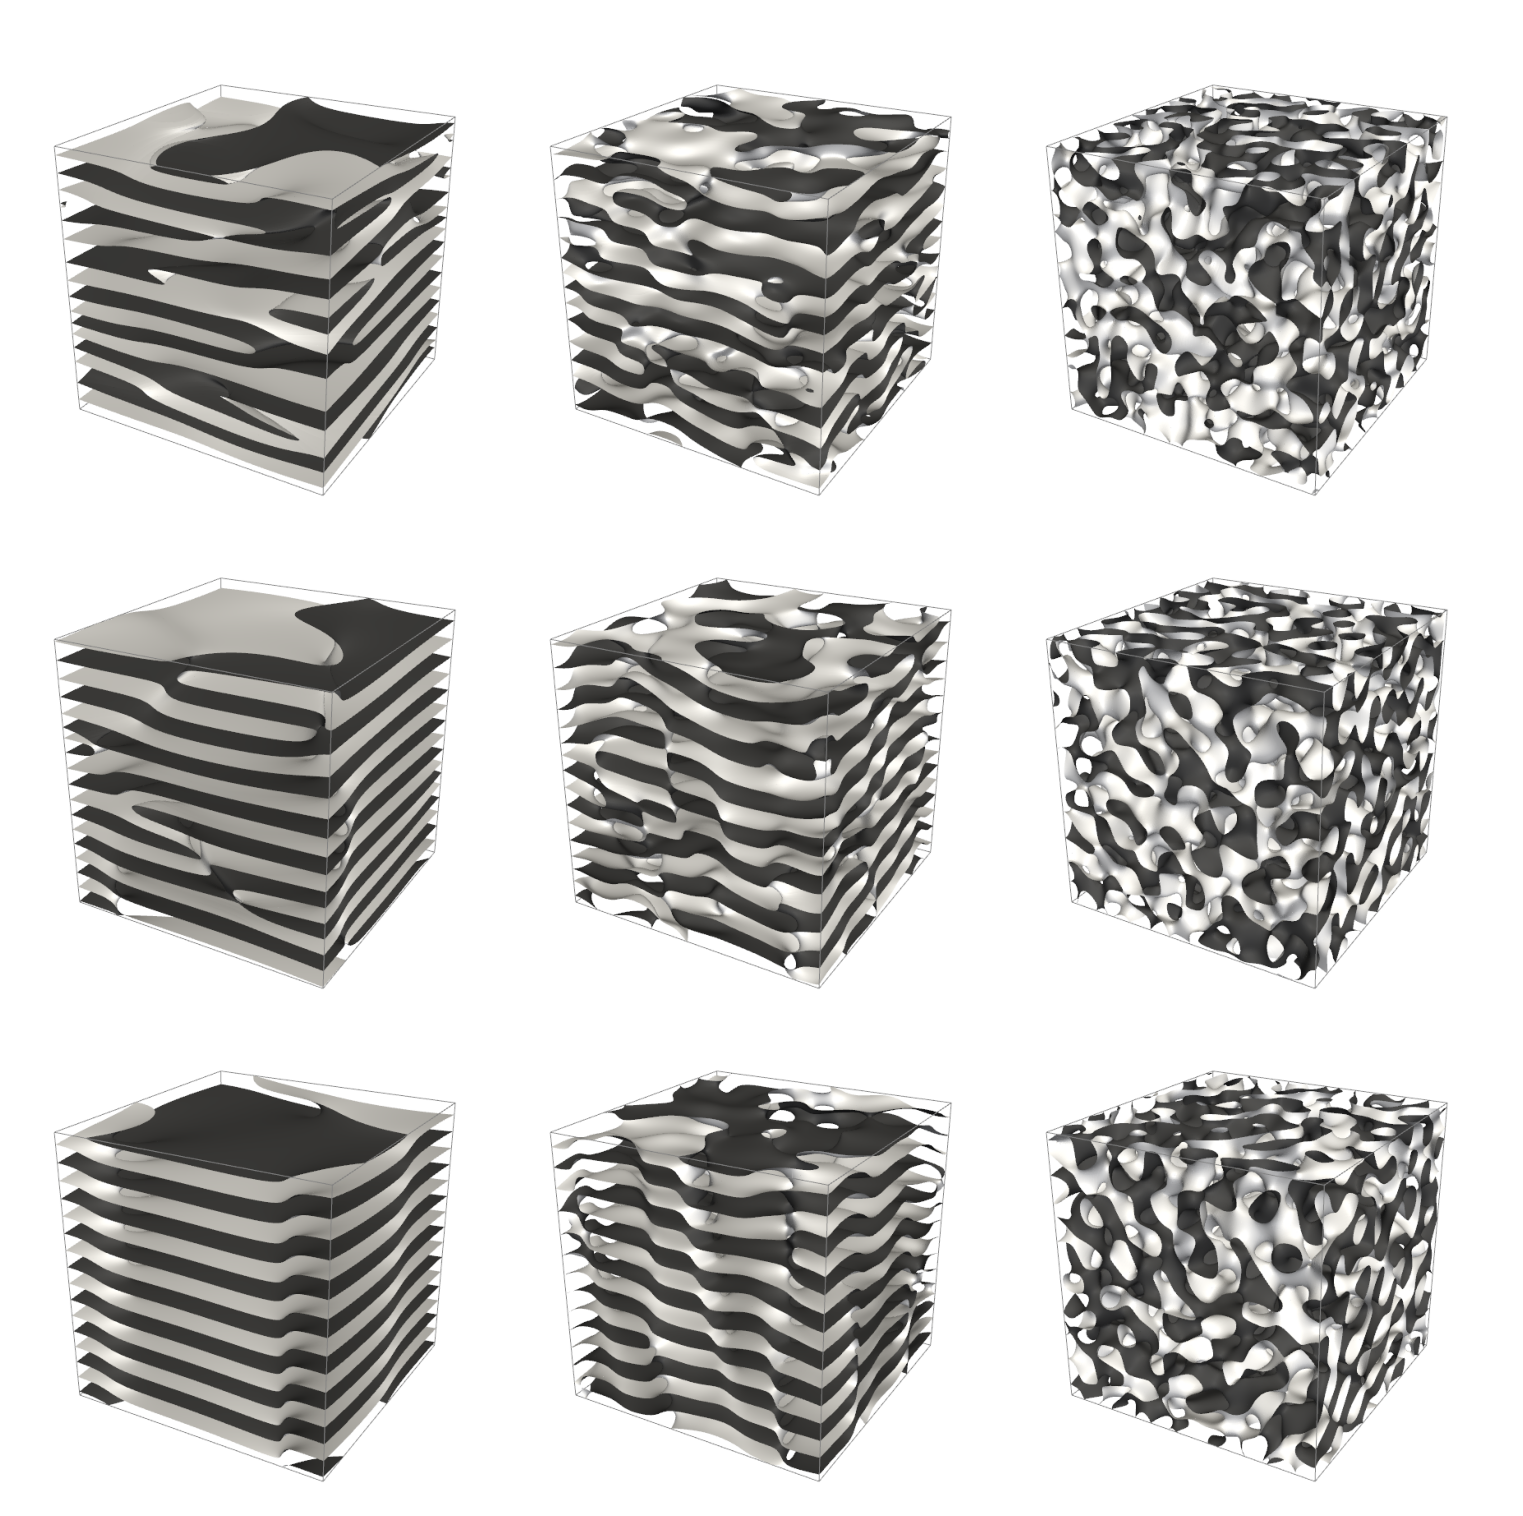

In [9]:
## Meshgrid
n_grid = 160
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)

r_grid = np.meshgrid(x,y,z) 

sigma_k_list = [0.2, 0.1, 0]
kappa_list = [256, 16, 1]

fig = plt.figure(figsize=(10, 10),dpi=192)

yy, xx = np.meshgrid(kappa_list,sigma_k_list)

parameters_list = []
rho_list = []
for i, (y,x) in enumerate(zip(yy.flatten(),xx.flatten())):
    ## Random wave
    # sigma_k = 0.025
    # kappa = 1
    alpha = 0

    parameters = [x,y,alpha]
    parameters_list.append(parameters)

    print('parameters = [{:0.1f}, {:0>3d}, {:0.2f}]'.format(*parameters))

    ax = plt.subplot(3,3,i+1)
    filename = './Figures/real_space/lamellar_{:0.3f}_{:0>3d}_{:0.2f}.png'.format(*parameters)

    img = np.asarray(Image.open(filename))
    ax.imshow(img)
    ax.axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()  

parameters = [0.2, 256, 0.00]
parameters = [0.2, 016, 0.00]
parameters = [0.2, 001, 0.00]
parameters = [0.1, 256, 0.00]
parameters = [0.1, 016, 0.00]
parameters = [0.1, 001, 0.00]
parameters = [0.0, 256, 0.00]
parameters = [0.0, 016, 0.00]
parameters = [0.0, 001, 0.00]


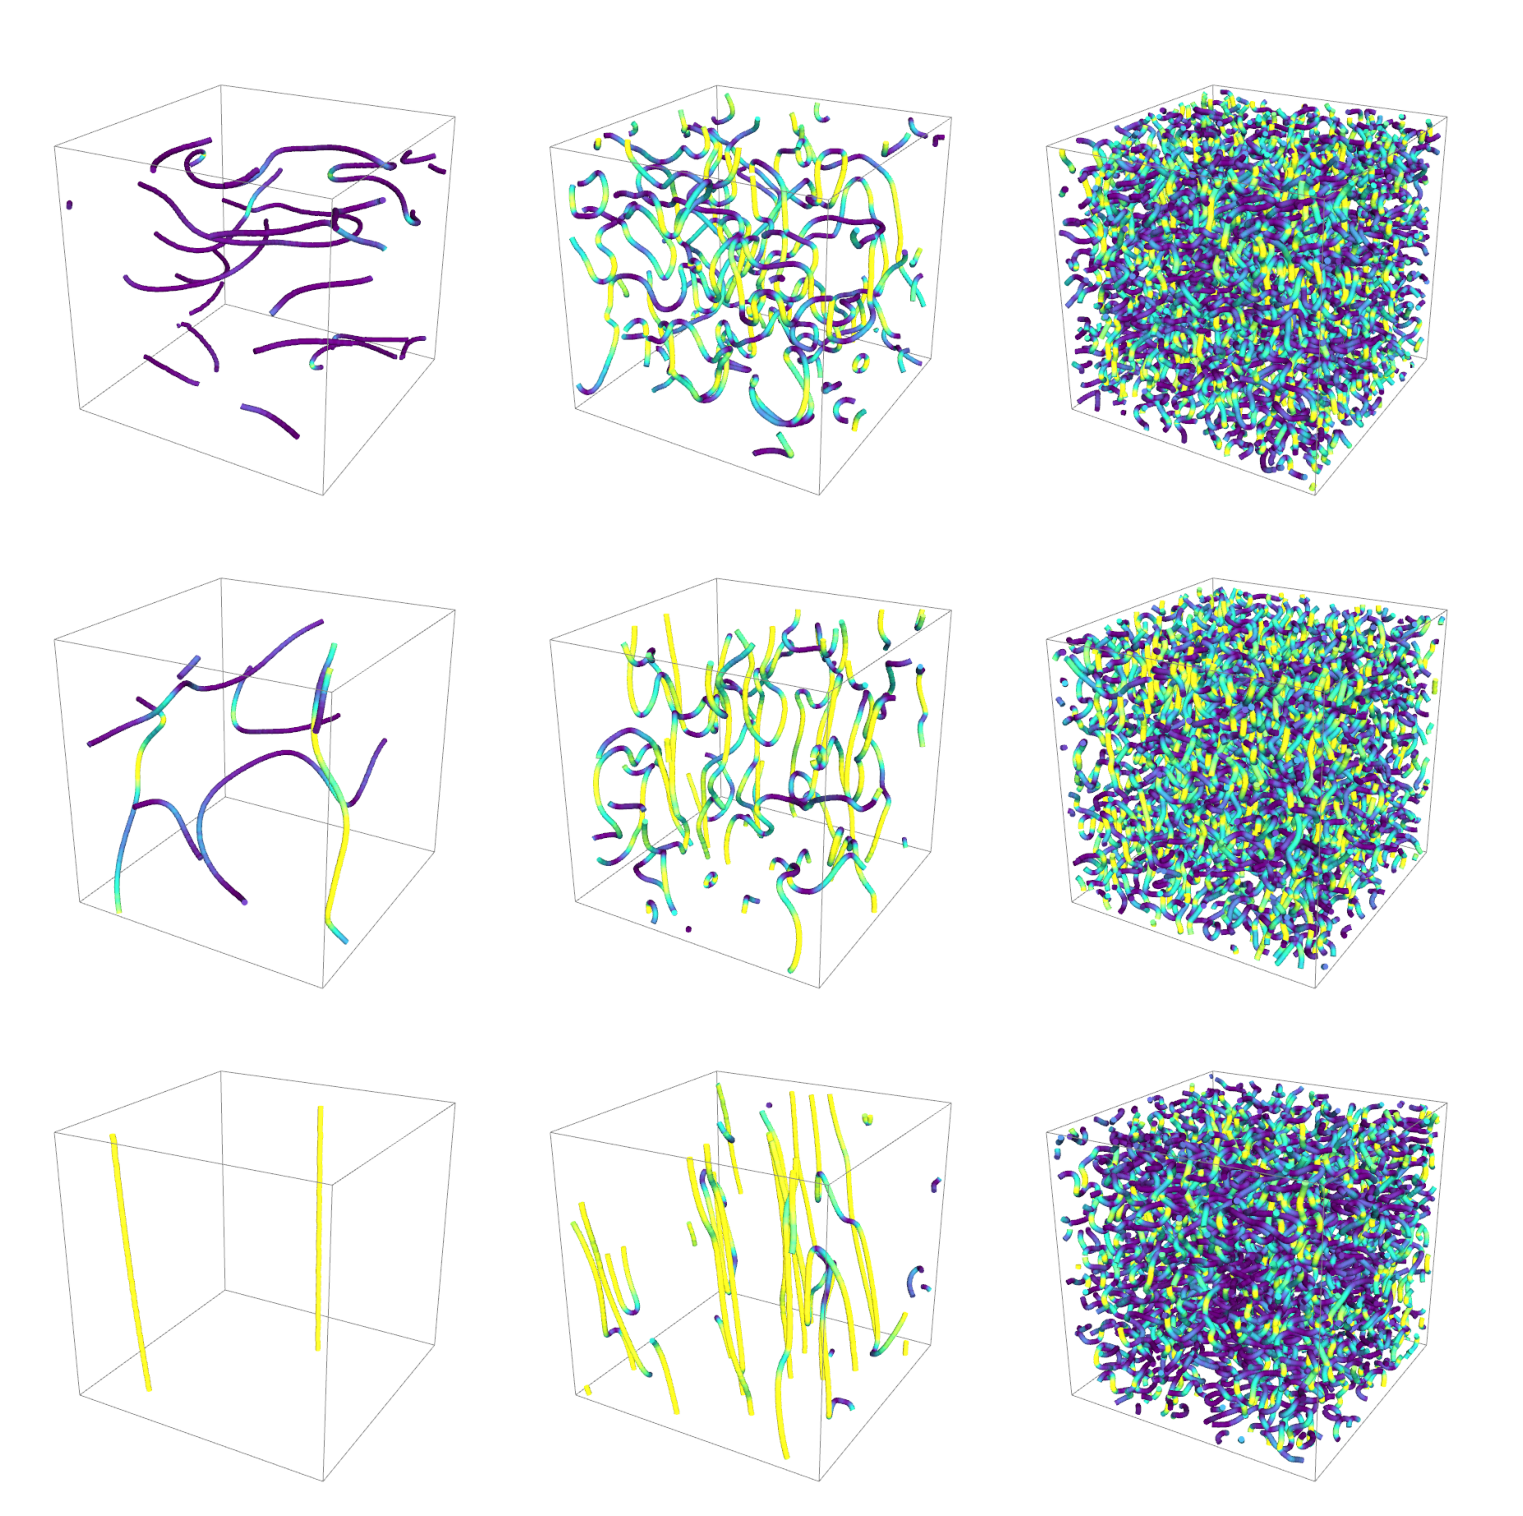

In [10]:
## Meshgrid
n_grid = 160
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)

r_grid = np.meshgrid(x,y,z) 

sigma_k_list = [0.2, 0.1, 0]
kappa_list = [256, 16, 1]

fig = plt.figure(figsize=(10, 10),dpi=192)

yy, xx = np.meshgrid(kappa_list,sigma_k_list)

parameters_list = []
rho_list = []
for i, (y,x) in enumerate(zip(yy.flatten(),xx.flatten())):
    ## Random wave
    # sigma_k = 0.025
    # kappa = 1
    alpha = 0

    parameters = [x,y,alpha]
    parameters_list.append(parameters)

    print('parameters = [{:0.1f}, {:0>3d}, {:0.2f}]'.format(*parameters))

    ax = plt.subplot(3,3,i+1)
    filename = './Figures/real_space/defect_{:0.3f}_{:0>3d}_{:0.2f}.png'.format(*parameters)

    img = np.asarray(Image.open(filename))
    ax.imshow(img)
    ax.axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()  

parameters = [0.2, 256, 0.00]
parameters = [0.2, 016, 0.00]
parameters = [0.2, 001, 0.00]
parameters = [0.1, 256, 0.00]
parameters = [0.1, 016, 0.00]
parameters = [0.1, 001, 0.00]
parameters = [0.0, 256, 0.00]
parameters = [0.0, 016, 0.00]
parameters = [0.0, 001, 0.00]


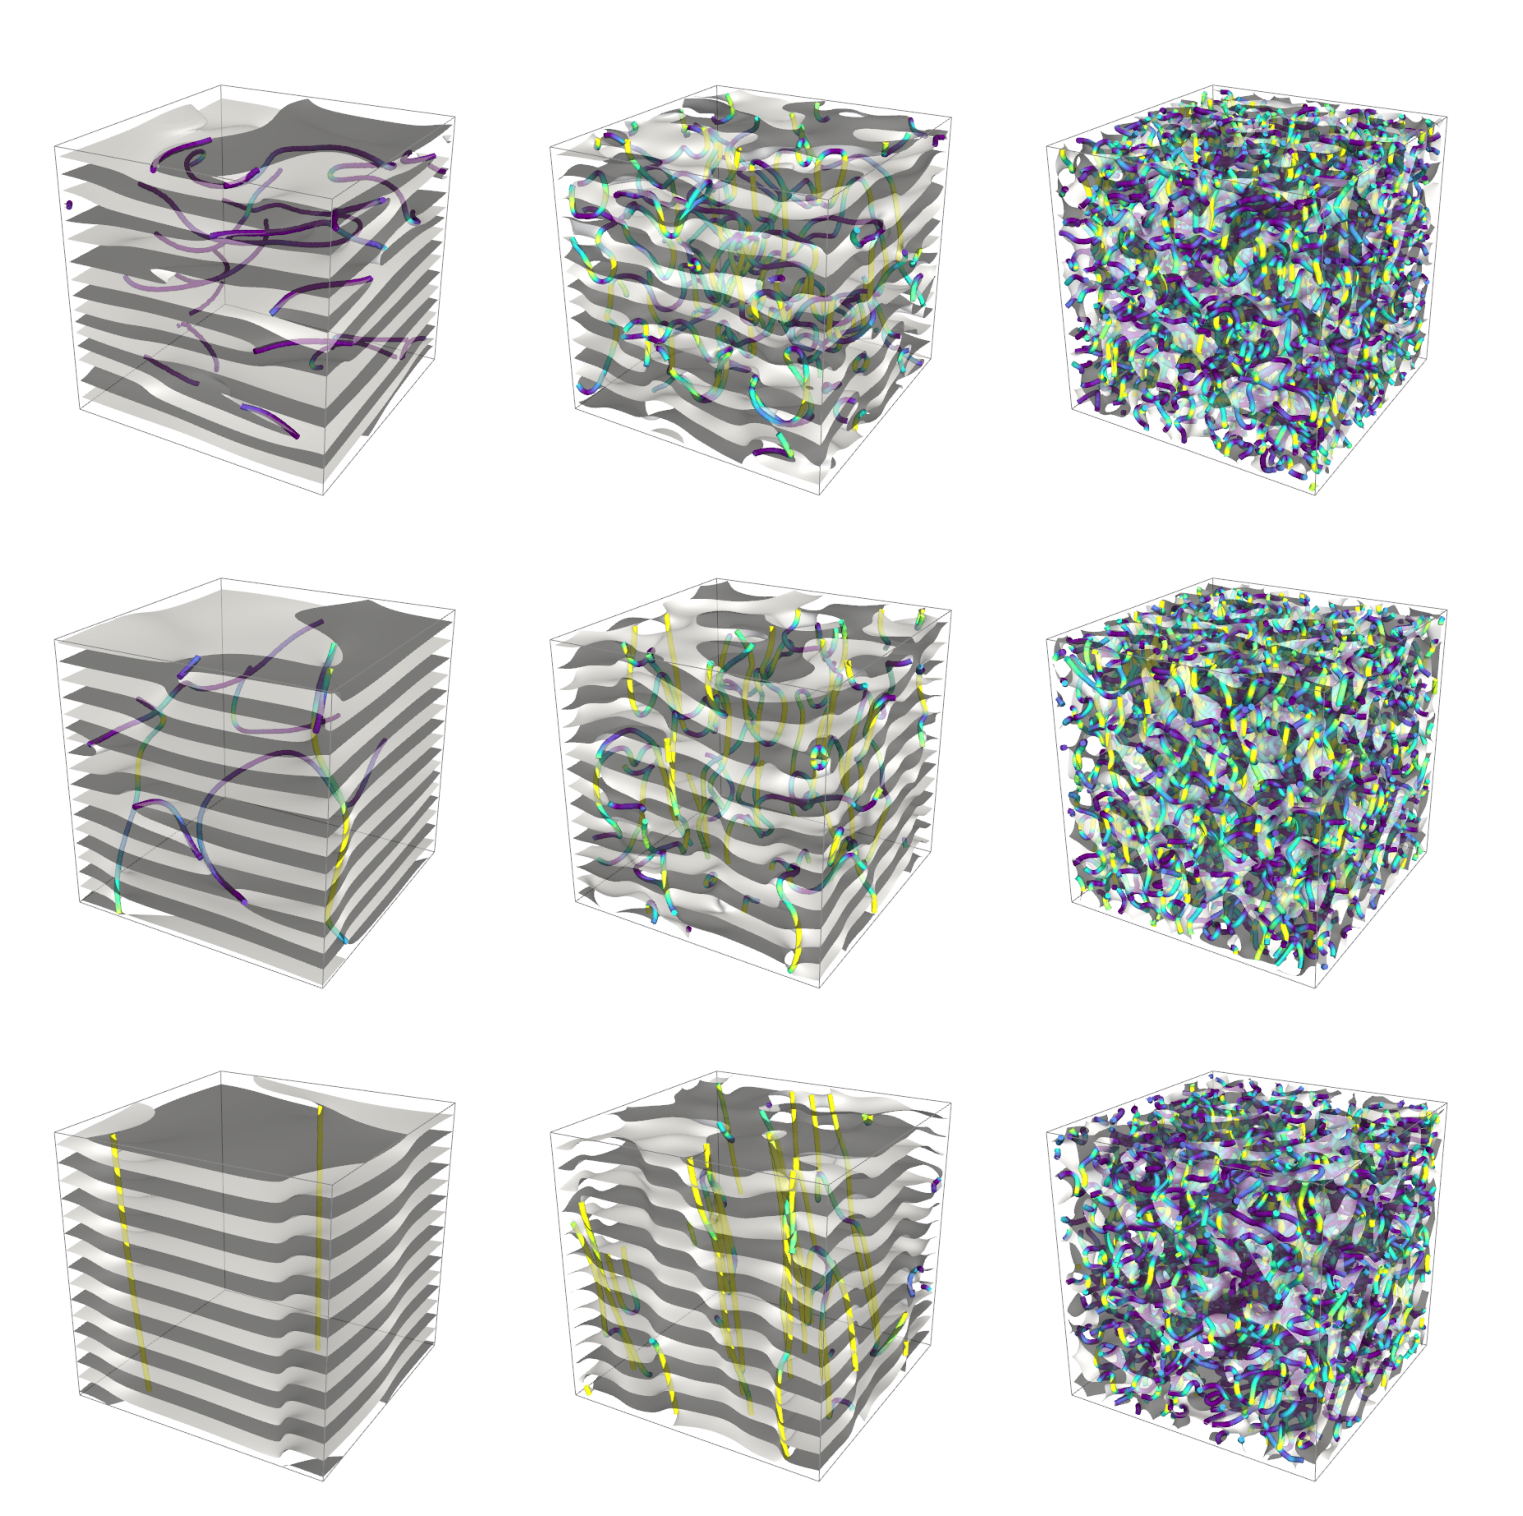

In [13]:
## Meshgrid
n_grid = 160
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)

r_grid = np.meshgrid(x,y,z) 

sigma_k_list = [0.2, 0.1, 0]
kappa_list = [256, 16, 1]

fig = plt.figure(figsize=(10, 10),dpi=192)

yy, xx = np.meshgrid(kappa_list,sigma_k_list)

parameters_list = []
rho_list = []
for i, (y,x) in enumerate(zip(yy.flatten(),xx.flatten())):
    ## Random wave
    # sigma_k = 0.025
    # kappa = 1
    alpha = 0

    parameters = [x,y,alpha]
    parameters_list.append(parameters)

    print('parameters = [{:0.1f}, {:0>3d}, {:0.2f}]'.format(*parameters))

    ax = plt.subplot(3,3,i+1)
    filename_defect = './Figures/real_space/defect_{:0.3f}_{:0>3d}_{:0.2f}.png'.format(*parameters)
    filename_lamellar = './Figures/real_space/overlap_{:0.3f}_{:0>3d}_{:0.2f}.png'.format(*parameters)

    img_defect = Image.open(filename_defect)
    img_lamellar = Image.open(filename_lamellar)
    blended = Image.blend(img_lamellar, img_defect, 0.33)

    img = np.asarray(blended)

    ax.imshow(img)
    ax.axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()  